# WCT Analysis

Whistle Contour Types (WCT) analysis. 

Exploration of the categories produced by ARTwarp and manual verifications

## Importations

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from WCT_analysis_utils import (run_SIGID, plot_wct_grid,
    categories_multi_dates, pairwise_tests, get_stars)

path_audio_folder = "/media/loic/Extreme SSD/Acoustique"

## Import data

In [2]:
results_df = pd.read_csv(
    "./resources/dtw_resources/contours_with_category.csv",
    index_col=0, parse_dates=["start_dt", "stop_dt"])   
results_df["date"] = pd.to_datetime(results_df["start_dt"].dt.date)
results_df["year"] = results_df["date"].dt.year
results_df["clean_activation_state"] = results_df["activation_state"].copy()
results_df.loc[results_df.clean_activation_state == 'Control', 'clean_activation_state'] = "BEF"

# rename isolated whistles to -1
cat_counts = np.unique(results_df.category, return_counts=True)
for cat, count in zip(cat_counts[0], cat_counts[1]):
    if cat == 0:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1
    elif count == 1:
        results_df.loc[results_df[results_df.category == cat].index, "category"] = -1

## SIGID

A method for the IDentification of SIGnature whistles (SIGID) developped by [Janik et al. 2013](https://onlinelibrary.wiley.com/doi/10.1111/j.1748-7692.2011.00549.x).

It relies on the analysis of WCTs: if 75% or more of the whistles of a WCT are within 1-10s of another similar whistle, then this WCT can be considered to be a SWT (Signature Whistles Type).

In [Fearey et al. 2019](http://link.springer.com/10.1007/s10071-019-01274-1), the authors consider a time-window of 0.2-10s for their study on common dolphins. As we are also working with *D.delphis*, let's compare these intervals.

### SWT identification

Identification of SWTs among the WCTs

In [3]:
intervals_to_try = [(0.2, 10), (1, 10)] # min and max for each time-window

In [4]:
# Identify SWTs (SIGID method)
for interval in tqdm(intervals_to_try, desc="SIGID interval", leave=True, position=0):
    results_df = run_SIGID(results_df, interval=interval)

# Difference in the number of SWT identified
results_df["SWT_difference"] = (
    results_df[f"SWT_[{intervals_to_try[0][0]},{intervals_to_try[0][1]}]"] !=
    results_df[f"SWT_[{intervals_to_try[1][0]},{intervals_to_try[1][1]}]"]
)
mismatch_whistles = results_df['SWT_difference'].sum()
mismatch_category = ((results_df.groupby('category')["SWT_difference"].sum()) > 1).sum()

print(f"\nDifferent intervals: {mismatch_category} mismatched SWTs (or {mismatch_whistles} SWs)")


SIGID interval: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Different intervals: 6 mismatched SWTs (or 50 SWs)


### Choosing SIGID interval

So using the original interval of [1, 10] sec we get different results than if we use the [0.2, 10] sec interval.

Which categories are classified differently?

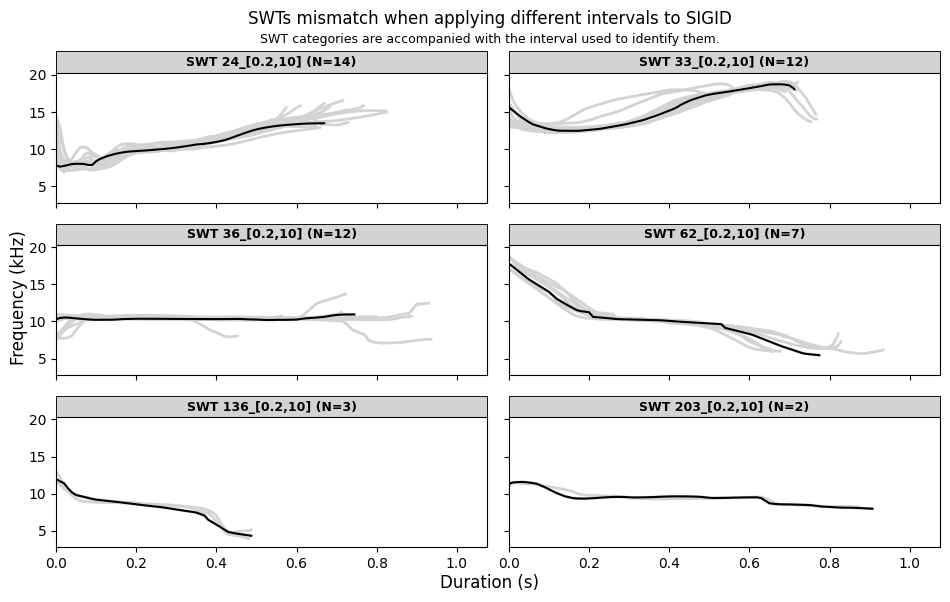

In [5]:
mismatch_df = results_df[results_df["SWT_difference"]].copy()
for id_row, row in mismatch_df.iterrows():
    if row["SWT_[1,10]"]:
        mismatch_df.loc[id_row, "category"] = str(row["category"])+"_[1,10]"
    else:
        mismatch_df.loc[id_row, "category"] = str(row["category"])+"_[0.2,10]"

misfig, misaxs = plot_wct_grid(mismatch_df, name="SWT ", rename=False)
misfig.suptitle("SWTs mismatch when applying different intervals to SIGID")
misfig.text(
    0.5, 0.925,
    "SWT categories are accompanied with the interval used to identify them.",
    ha="center", fontsize=9)
misfig.subplots_adjust(bottom=0.085, top=0.875)
misfig.set_size_inches(10, 6)
misfig.savefig("/home/loic/Pictures/CDD/SWTs_interval_mismatch.pdf")
plt.show()

Ok, so all the additional SWTs come from the selection of WCTs using the [0.2, 10] sec interval.

Since, this interval was specifically create for *D. delphis* whistles, we keep this interval for further analyses.

In [6]:
the_interval = "SWT_[0.2,10]"
print(f"Choosing interval: {the_interval}")
results_df['is_SW'] = results_df[the_interval].astype(int)

Choosing interval: SWT_[0.2,10]


## SWT data summary

### Zipf's law

all WCTs Pareto fit: D=0.21 (p=1.06e-08, Does not fit)
NSWTs Pareto fit: D=0.27 (p=5.77e-09, Does not fit)
SWTs Pareto fit: D=0.12 (p=1.59e-01, possibly a correct fit)


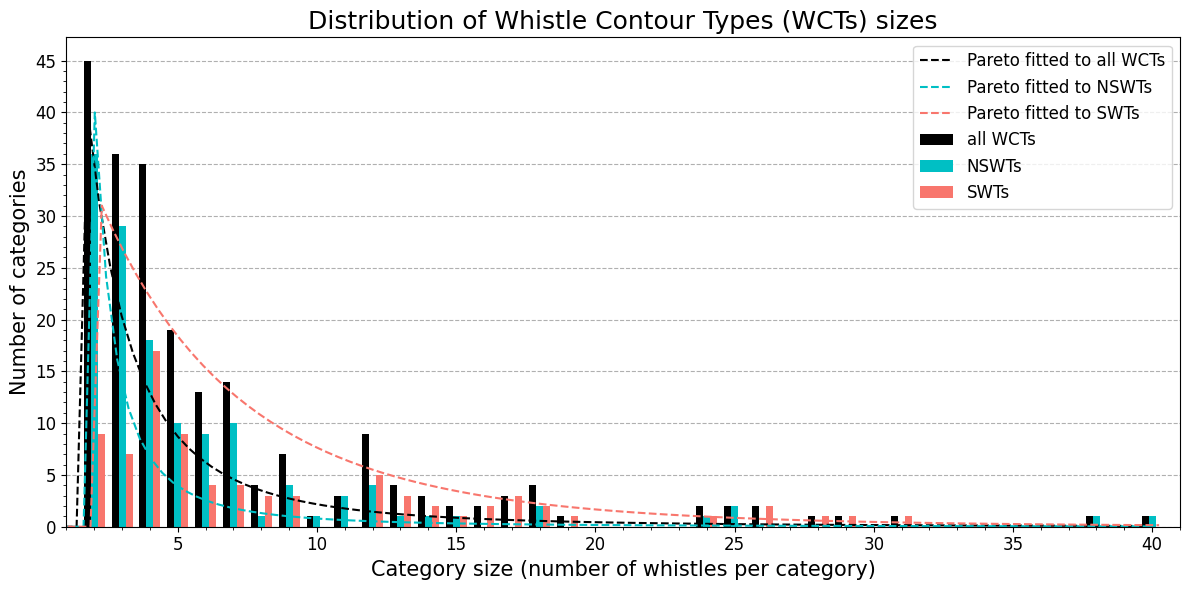

In [7]:
# Distribution plots
wct_no_swt_sizes = results_df[results_df["is_SW"]==0]['category'].value_counts().drop(index=-1)
wct_sizes = results_df['category'].value_counts().drop(index=-1)
swt_sizes = results_df[results_df["is_SW"]==1]['category'].value_counts()

# Barplot
width = 0.25 # max 0.33
bar_fig, bar_ax = plt.subplots(1, 1, figsize=(12,6))
for i, (size_list, name, color) in enumerate(zip(
        [wct_sizes, wct_no_swt_sizes, swt_sizes], 
        ["all WCTs", "NSWTs", "SWTs"],
        ["black", "#00BFC4", "#F8766D"]
        )):
    
    size_distribution = pd.DataFrame({
        'Category Size': size_list.values,
        'Number of Categories': [1] * len(size_list)
        }).groupby('Category Size')['Number of Categories'].sum().reset_index()
    size_distribution['Category Size'] = pd.to_numeric(size_distribution['Category Size'])
    
    if i == 0:
        factor = -1
    if i == 1:
        factor = 0
    if i == 2:
        factor = 1
    bar_ax.bar(
        x=np.array(size_distribution['Category Size'])+factor*width, 
        height=size_distribution['Number of Categories'],
        label=name, width=width, color=color)

    
    # Fits a power law of distribution ?
    x = np.linspace(0, 40, 100)
    shape, loc, scale = stats.pareto.fit(size_list)
    bar_ax.plot(
        x+factor*width, 
        max(size_list)*stats.pareto.pdf(x, shape, loc, scale)/max(stats.pareto.pdf(x, shape, loc, scale)), 
        '--', label=f"Pareto fitted to {name}", color=color)
    D, p_value = stats.kstest(size_list, "pareto", args=(shape, loc, scale))
    print(f"{name} Pareto fit: D={D:.2f} (p={p_value:.2e}, {'Does not fit' if p_value < 0.05 else 'possibly a correct fit'})")


bar_ax.set_title('Distribution of Whistle Contour Types (WCTs) sizes', fontsize=18)
bar_ax.set_xlabel('Category size (number of whistles per category)', fontsize=15)
bar_ax.set_ylabel('Number of categories', fontsize=15)

major_ticks = np.arange(0,46,5)
minor_ticks = np.arange(0,46,1)

bar_ax.set_xticks(major_ticks)
bar_ax.set_xticks(minor_ticks, minor=True)
bar_ax.set_yticks(major_ticks)
bar_ax.set_yticks(minor_ticks, minor=True)

bar_ax.grid(visible=True, which="major", axis='y', linestyle='--', alpha=1)
bar_ax.legend(prop={'size': 12})
bar_ax.set_xlim(1, 41)
bar_ax.tick_params(axis='both', labelsize=12)
bar_ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
bar_fig.tight_layout()
bar_fig.savefig("/home/loic/Pictures/CDD/WCTs_SWTs_distribution.pdf")
plt.show()

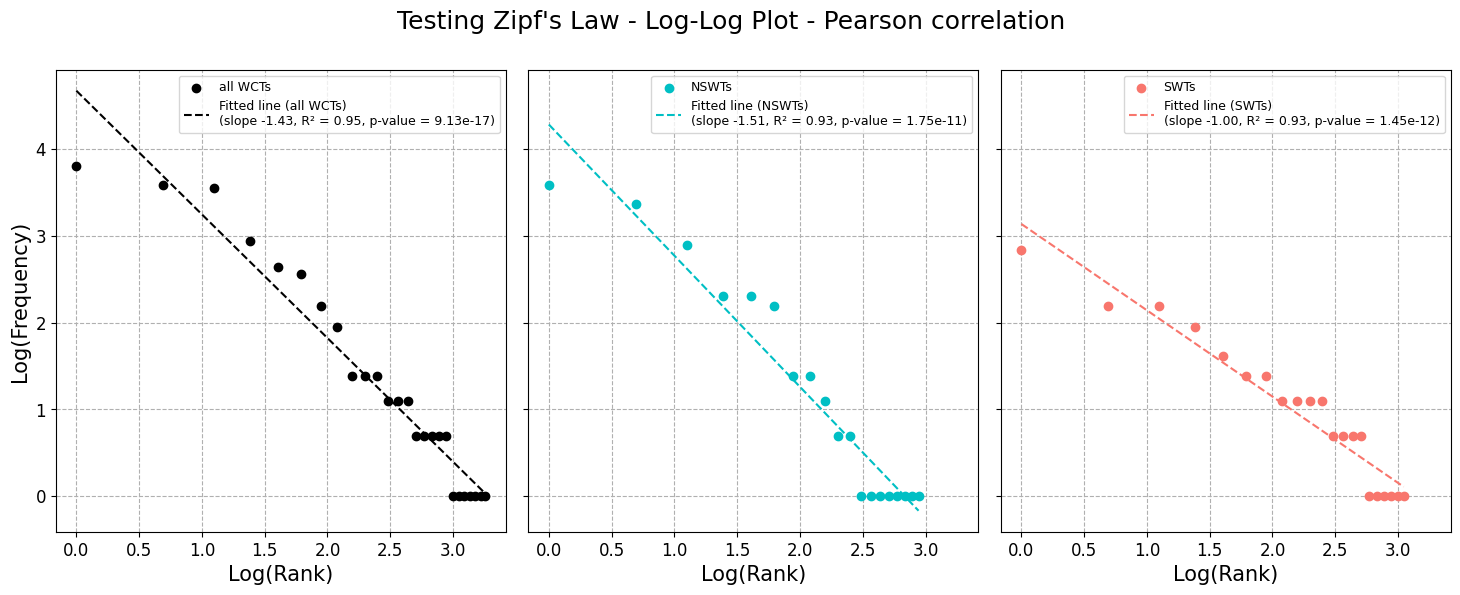

In [8]:
# Distribution plots
wct_no_swt_sizes = results_df[results_df["is_SW"]==0]['category'].value_counts().drop(index=-1)
wct_sizes = results_df['category'].value_counts().drop(index=-1)
swt_sizes = results_df[results_df["is_SW"]==1]['category'].value_counts()

# Barplot
zipf_fig, zipf_ax = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
for i, (size_list, name, color) in enumerate(zip(
        [wct_sizes, wct_no_swt_sizes, swt_sizes], 
        ["all WCTs", "NSWTs", "SWTs"],
        ["black", "#00BFC4", "#F8766D"]
        )):
    
    size_distribution = pd.DataFrame({
        'Category Size': size_list.values,
        'Number of Categories': [1] * len(size_list)
        }).groupby('Category Size')['Number of Categories'].sum().reset_index()
    size_distribution['Category Size'] = pd.to_numeric(size_distribution['Category Size'])
    
    # Calculate log values for plotting
    sorted_df = size_distribution.sort_values(by="Number of Categories", ascending=False).reset_index(drop=True)
    sorted_df['rank'] = sorted_df.index + 1
    sorted_df['log_rank'] = np.log(sorted_df['rank'])
    sorted_df['log_frequency'] = np.log(sorted_df["Number of Categories"])
    
    # Calculate expected Zipf values (proportional to 1/rank)
    # Use the first value to normalize
    first_value = sorted_df["Number of Categories"].iloc[0]
    sorted_df['expected_zipf'] = first_value / sorted_df['rank']
    sorted_df['log_expected_zipf'] = np.log(sorted_df['expected_zipf'])

    # Perform linear regression on log-log data
    pearson_results = stats.linregress(sorted_df['log_rank'], sorted_df['log_frequency'])
    slope, intercept, r_value, p_value, std_err = pearson_results

    zipf_ax[i].scatter(
        x=sorted_df['log_rank'], y=sorted_df['log_frequency'], 
        color=color, label=name)

    zipf_ax[i].plot(
        sorted_df['log_rank'], 
        intercept + slope * sorted_df['log_rank'], 
        linestyle='dashed', color=color, label=f'Fitted line ({name})\n(slope {slope:.2f}, R² = {r_value**2:.2f}, p-value = {p_value:.2e})')

    zipf_ax[i].set_xlabel('Log(Rank)', fontsize=15)
    zipf_ax[i].legend(prop={'size': 9})
    zipf_ax[i].tick_params(axis='both', labelsize=12)
    zipf_ax[i].grid(True, linestyle='--', alpha=1)
    zipf_ax[i].set_axisbelow(True)

zipf_ax[0].set_ylabel('Log(Frequency)', fontsize=15)
# Adjust layout to prevent label cutoff
zipf_fig.subplots_adjust(wspace=0.05)
zipf_fig.suptitle("Testing Zipf's Law - Log-Log Plot - Pearson correlation", fontsize=18)
zipf_fig.savefig("/home/loic/Pictures/CDD/WCTs_SWTs_Zipf_law.pdf")
plt.show()

For the interpretation, idk for now, but please use http://biorxiv.org/lookup/doi/10.1101/2023.01.11.523588 and https://www.mdpi.com/1099-4300/11/4/688

100%|██████████| 1000/1000 [00:07<00:00, 131.06it/s]


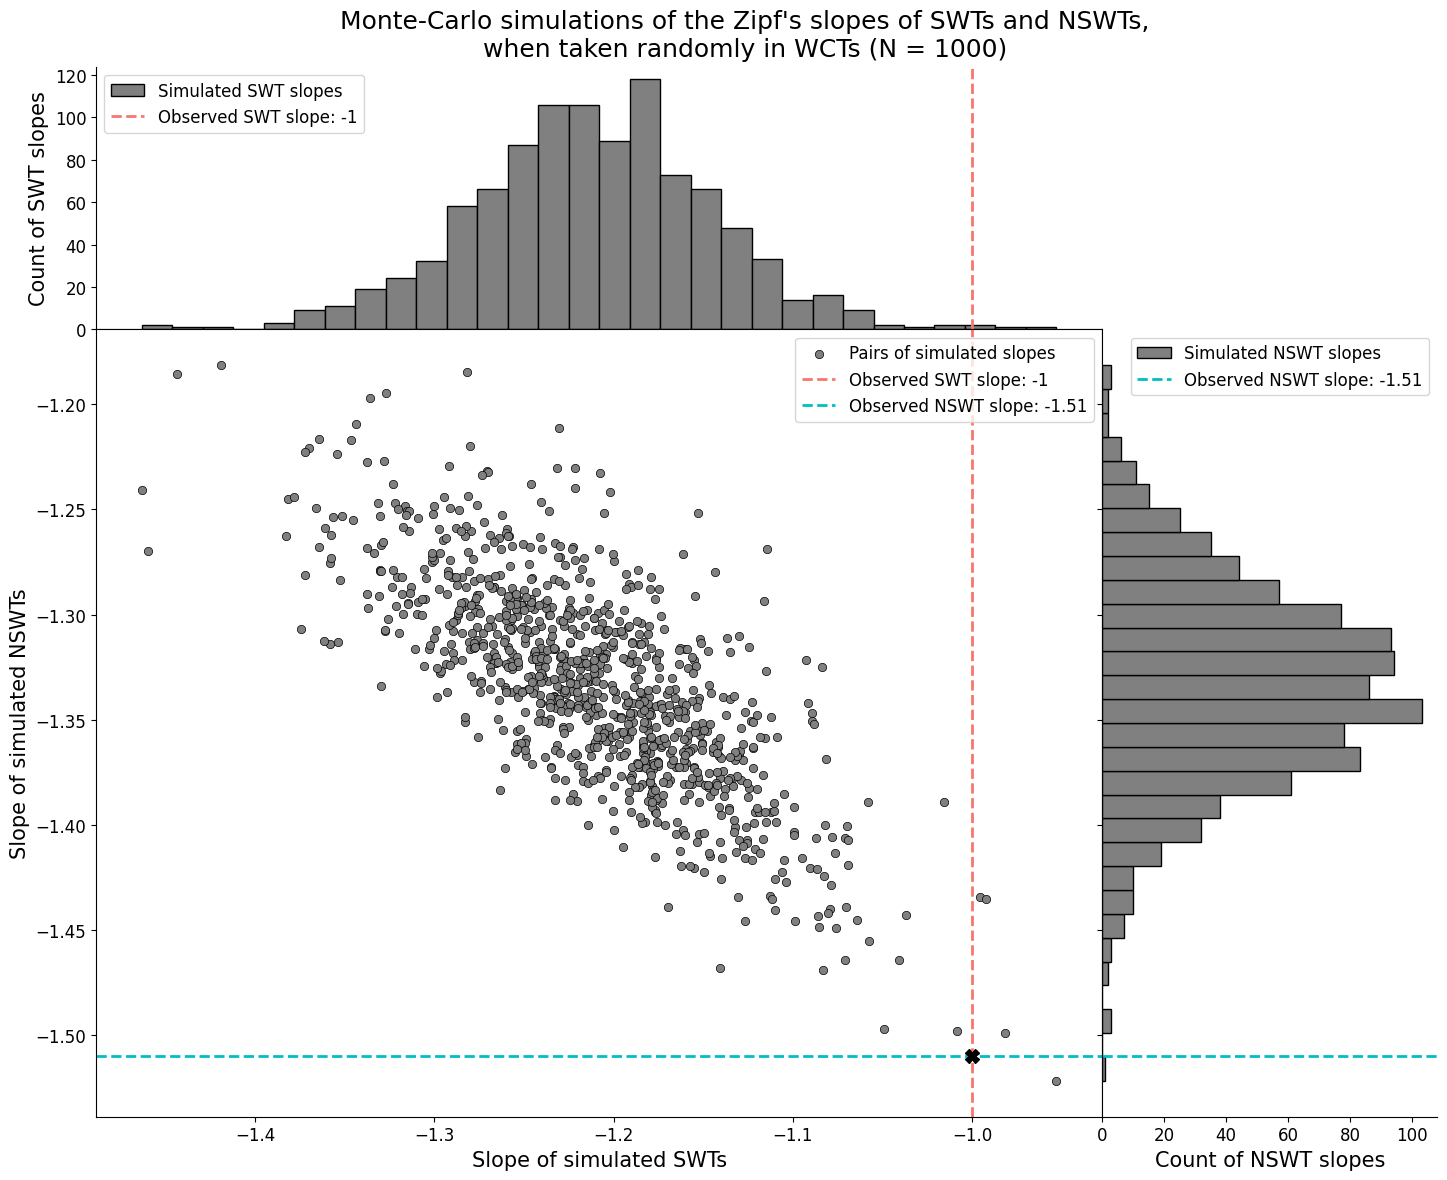

Probability of randomly obtaining a subgroup SWT slope >= -1: 4.0000e-03
Probability of randomly obtaining a subgroup NSWT slope <= -1.51: 1.0000e-03
Probability of randomly obtaining a slope difference >= 0.51: 2.0000e-03


In [9]:
# Monte Carlo Simulation
# take a random subgroup A, and B its complement
# compare their Zipf slopes
np.random.seed(69)
SWT_slope = -1
NSWT_slope = -1.51
N_simulations = 1000
proprotion_of_swts = results_df[results_df[the_interval]].category.nunique()/results_df.category.nunique()

results = []
for i in tqdm(range(N_simulations), leave=True):
    # create random A and B subgroups
    new_order = np.random.permutation(wct_sizes.to_numpy())
    A_subgroup = new_order[:int(len(wct_sizes)*proprotion_of_swts)]
    B_subgroup = new_order[int(len(wct_sizes)*proprotion_of_swts):]    

    # compute zipf slopes
    local_results = {'simulation': i}
    for subgroup, name in zip([A_subgroup, B_subgroup], ["a", "b"]):
        size_distribution = pd.DataFrame({
            'Category Size': subgroup,
            'Number of Categories': [1] * len(subgroup)
            }).groupby('Category Size')['Number of Categories'].sum().reset_index()
        size_distribution['Category Size'] = pd.to_numeric(size_distribution['Category Size'])

        # Calculate log values for plotting
        sorted_df = size_distribution.sort_values(by="Number of Categories", ascending=False).reset_index(drop=True)
        sorted_df['rank'] = sorted_df.index + 1
        sorted_df['log_rank'] = np.log(sorted_df['rank'])
        sorted_df['log_frequency'] = np.log(sorted_df["Number of Categories"])

        # Calculate expected Zipf values (proportional to 1/rank)
        # Use the first value to normalize
        first_value = sorted_df["Number of Categories"].iloc[0]
        sorted_df['expected_zipf'] = first_value / sorted_df['rank']
        sorted_df['log_expected_zipf'] = np.log(sorted_df['expected_zipf'])

        # Perform linear regression on log-log data
        pearson_results = stats.linregress(sorted_df['log_rank'], sorted_df['log_frequency'])
        slope, intercept, r_value, p_value, std_err = pearson_results

        local_results[f'subgroup_{name}_slope'] = slope
        local_results[f'subgroup_{name}_r2'] = r_value**2
        local_results[f'subgroup_{name}_p_value'] = p_value
    
    local_results['slope_difference'] = local_results['subgroup_a_slope'] - local_results['subgroup_b_slope']
    results.append(local_results)
sim_results = pd.DataFrame(results)

# Show results in figure
if True:
    sim_fig, sim_ax = plt.subplots(
        2, 2, figsize=(15, 12), sharex="col", sharey="row",
        gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
    
    # Histogram of subgroup A slopes
    sim_ax[0, 0].hist(
        sim_results['subgroup_a_slope'], bins=30,
        facecolor="gray", edgecolor="black", label="Simulated SWT slopes")
    sim_ax[0, 0].axvline(SWT_slope, color="#F8766D", linestyle='dashed', 
                        linewidth=2, label=f'Observed SWT slope: {SWT_slope}')
    sim_ax[0, 0].set_ylabel('Count of SWT slopes', fontsize=15)
    sim_ax[0, 0].tick_params(axis='both', labelsize=12)
    sim_ax[0, 0].legend(prop={'size': 12})
    sim_ax[0, 0].spines['top'].set_visible(False)
    sim_ax[0, 0].spines['right'].set_visible(False)

    # Scatter plot of slopes
    sim_ax[1, 0].scatter(
        sim_results['subgroup_a_slope'], sim_results['subgroup_b_slope'], 
        color="gray", edgecolor='black', lw=0.5, label="Pairs of simulated slopes")
    sim_ax[1, 0].axvline(
        SWT_slope, color="#F8766D", linestyle='dashed', linewidth=2,
        label=f'Observed SWT slope: {SWT_slope}')
    sim_ax[1, 0].axhline(
        NSWT_slope, color="#00BFC4", linestyle='dashed', linewidth=2,
        label=f'Observed NSWT slope: {NSWT_slope}')
    sim_ax[1, 0].plot(
        SWT_slope, NSWT_slope, color="black", marker="X", markersize=10)
    sim_ax[1, 0].set_xlabel('Slope of simulated SWTs', fontsize=15)
    sim_ax[1, 0].set_ylabel('Slope of simulated NSWTs', fontsize=15)
    sim_ax[1, 0].tick_params(axis='both', labelsize=12)
    sim_ax[1, 0].legend(prop={'size': 12})

    # Histogram of subgroup B slopes
    sim_ax[1, 1].hist(
        sim_results['subgroup_b_slope'], bins=30, orientation='horizontal',
        facecolor="gray", edgecolor="black", label="Simulated NSWT slopes")
    sim_ax[1, 1].axhline(NSWT_slope, color="#00BFC4", linestyle='dashed', 
                        linewidth=2, label=f'Observed NSWT slope: {NSWT_slope}')
    sim_ax[1, 1].set_xlabel('Count of NSWT slopes', fontsize=15)
    sim_ax[1, 1].tick_params(axis='both', labelsize=12)
    sim_ax[1, 1].legend(prop={'size': 12})
    sim_ax[1, 1].spines['top'].set_visible(False)
    sim_ax[1, 1].spines['right'].set_visible(False)

    sim_fig.suptitle(f"Monte-Carlo simulations of the Zipf's slopes of SWTs and NSWTs,\nwhen taken randomly in WCTs (N = {N_simulations})", fontsize=18)
    sim_fig.delaxes(ax=sim_ax[0,1])
    sim_fig.tight_layout()
    sim_fig.subplots_adjust(wspace=0, hspace=0)
    sim_fig.savefig("/home/loic/Pictures/CDD/simulation_Zipf_law.pdf")
    plt.show()

# Calculate p-value for obtaining the observed slopes or more extreme
p_value_a = np.mean(sim_results['subgroup_a_slope'] >= SWT_slope)
p_value_b = np.mean(sim_results['subgroup_b_slope'] <= NSWT_slope)
p_value_diff = np.mean(sim_results['slope_difference'] >= abs(SWT_slope - NSWT_slope))

print(f"Probability of randomly obtaining a subgroup SWT slope >= {SWT_slope}: {p_value_a:.4e}")
print(f"Probability of randomly obtaining a subgroup NSWT slope <= {NSWT_slope}: {p_value_b:.4e}")
print(f"Probability of randomly obtaining a slope difference >= {abs(SWT_slope - NSWT_slope):.2f}: {p_value_diff:.4e}")

Accordance with Zipf's law:
- SWTs follow Zipf's Law almost perfectly (slope ≈ -1, p-value < 0.01)
- NSWT have a steeper distribution (slope ≈ -1.5, p-value < 0.01)

These differences cannot be explained by random sampling

### Overview

In [10]:
print(f"Mean duration (WCTs): {results_df[results_df.category != -1].duration.mean():.2f}")
print(f"Mean duration (isolated whistles): {results_df[results_df.category == -1].duration.mean():.2f}")

Mean duration (WCTs): 0.88
Mean duration (isolated whistles): 0.52


In [11]:
print("\nAmong all whistles:")
print(f"\tSWTs represent {100*results_df[results_df[the_interval]].category.nunique()/results_df.category.nunique():.2f}% of WCTs ({results_df[results_df[the_interval]].category.nunique()}/{results_df.category.nunique()}).")
print(f"\tSWs represent {100*results_df[the_interval].sum()/len(results_df):.2f}% of whistles ({results_df[the_interval].sum()}/{len(results_df)}).")


Among all whistles:
	SWTs represent 37.33% of WCTs (81/217).
	SWs represent 6.04% of whistles (699/11575).


In [12]:
# What about the ID of each group of dolphin ?
group_ID_datetime = pd.read_csv(
    "./resources/DF-whistles/group_ID_datetime.csv", 
    parse_dates=["datetime_utc"])
results_df["ID_group"] = None

for row_id, row in tqdm(results_df.iterrows(), total=len(results_df)):
    corr_row = group_ID_datetime[group_ID_datetime["datetime_utc"] <= row["start_dt"]].iloc[-1]
    results_df.loc[row_id, "ID_group"] = corr_row["ID_group"]

100%|██████████| 11575/11575 [00:09<00:00, 1280.03it/s]


In [13]:
# is each WCT or SWT specific to a specific sequence
print(f"Average number of sequences associated to a specific WCT: {results_df[results_df['is_SW']==0].groupby('category')['sequence'].nunique().mean():.2f}")
print(f"Average number of sequences associated to a specific SWT: {results_df[results_df['is_SW']==1].groupby('category')['sequence'].nunique().mean():.2f}")

Average number of sequences associated to a specific WCT: 1.57
Average number of sequences associated to a specific SWT: 1.06


In [14]:
# is each WCT or SWT specific to a specific sequence
print(f"Average number of groups associated to a specific WCT: {results_df[results_df['is_SW']==0].groupby('category')['ID_group'].nunique().mean():.2f}")
print(f"Average number of groups associated to a specific SWT: {results_df[results_df['is_SW']==1].groupby('category')['ID_group'].nunique().mean():.2f}")

# very slight difference but overall, one SWT = 1 group of dolphin.
# But on average 1.3 sequence pour WCT. So probably shared WCTs.

Average number of groups associated to a specific WCT: 1.28
Average number of groups associated to a specific SWT: 1.07


In [15]:
n_SW_per_file = []
n_SW_per_file_per_dolphin = []
for year in ["2020", "2021", "2022"]:
    for date in os.listdir(os.path.join(path_audio_folder, year)):
        if date.startswith(".") or date.endswith(".txt") or date.endswith(".xlsx"):
            continue
        for file in os.listdir(os.path.join(path_audio_folder, year, date)):
            if file.endswith(".wav") and (not file.startswith(".")):
                table = results_df[
                    ((results_df['is_SW']==1) &
                    (results_df['file']==datetime.strptime(file[8:-4], "%Y%m%d_%H%M%S").strftime("%Y-%m-%d_%H:%M")))
                    ]
                if len(table) >= 1:
                    n_SW_per_file += [len(table)]
                    n_SW_per_file_per_dolphin += [len(table)/table.group_size.iloc[0]]
                else:
                    n_SW_per_file += [0]
                    n_SW_per_file_per_dolphin += [0]

print("SW rate (per minute):", "{:.2f}".format(np.mean(n_SW_per_file)))
print("SW rate (per minute per dolphin):", "{:.2f}".format(np.nanmean(n_SW_per_file_per_dolphin)))

SW rate (per minute): 0.85
SW rate (per minute per dolphin): 0.14


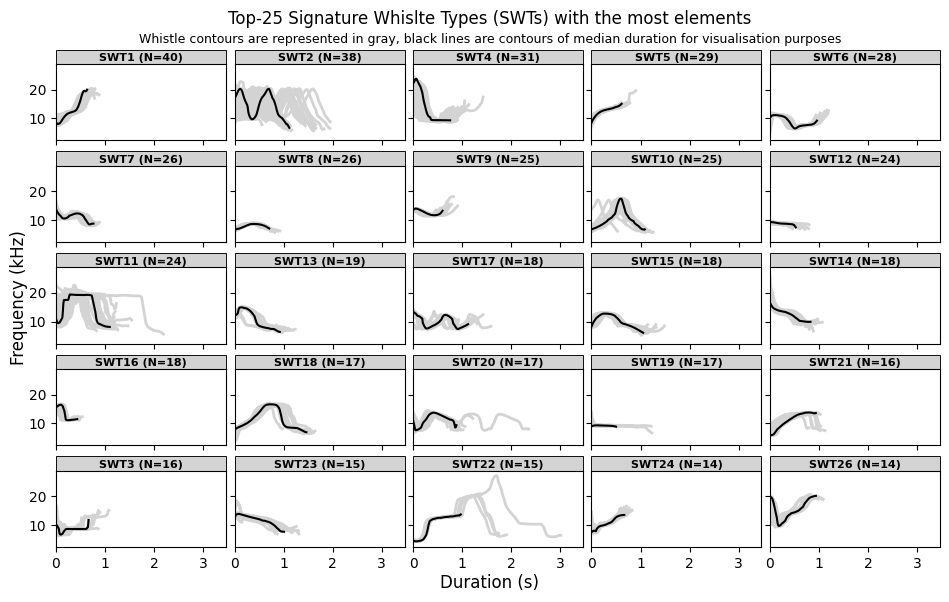

In [16]:
# display best contours
results_df_grouped = results_df.drop(index=results_df[results_df.category==-1].index, inplace=False).copy()
gridfig, gridaxs = plot_wct_grid(
    results_df_grouped, mode="median_dur",
    name="SWT", n_categories=25, rename=False)
gridfig.suptitle("Top-25 Signature Whislte Types (SWTs) with the most elements")
gridfig.text(
    0.5, 0.925,
    "Whistle contours are represented in gray, black lines are contours of median duration for visualisation purposes",
    ha="center", fontsize=9)
gridfig.subplots_adjust(bottom=0.085, top=0.89)
gridfig.set_size_inches(10, 6)
for axs in gridaxs:
    for ax in axs:
        ax.get_children()[-11].set_height(5)
        ax.set_title(
            ax.get_children()[-4].get_text(),
            pad=2, 
            fontsize=8,
            fontweight='bold')
gridfig.savefig("/home/loic/Pictures/CDD/SWTs_25.pdf")
plt.show()

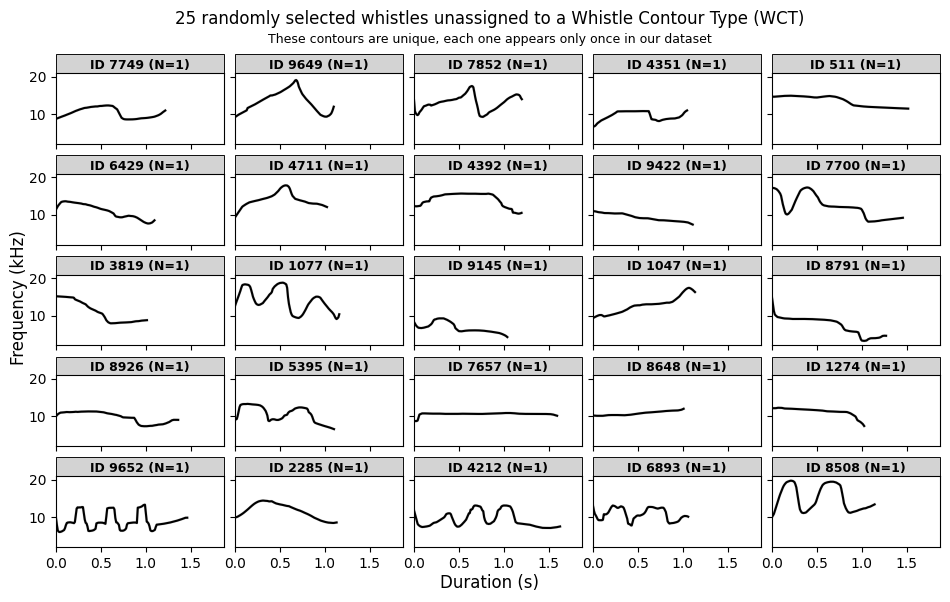

# isolated whistles: 10106


In [17]:
# display uncategorised contours
isolated_df = results_df[results_df.category==-1].copy()
isolated_df["category"] = np.arange(len(isolated_df), dtype=int)

sinfig, sinaxs = plot_wct_grid(
    isolated_df.loc[np.random.RandomState(seed=246).permutation(isolated_df[isolated_df.duration > 1].index)[:25]], 
    name="ID ", n_categories=25, rename=False)
sinfig.suptitle("25 randomly selected whistles unassigned to a Whistle Contour Type (WCT)")
sinfig.text(
    0.5, 0.925,
    "These contours are unique, each one appears only once in our dataset",
    ha="center", fontsize=9)
sinfig.subplots_adjust(
    bottom=0.085, top=0.875, 
    hspace=0.42, wspace=0.066)
sinfig.set_size_inches(10, 6)
for axs in sinaxs:
    for ax in axs:
        ax.get_children()[-11].set_height(5)
        ax.set_title(
            ax.get_children()[-4].get_text(),
            pad=3, 
            fontsize=9,
            fontweight='bold')
sinfig.savefig("/home/loic/Pictures/CDD/isolated_25.pdf")
plt.show()

print("# isolated whistles:", len(isolated_df))

## SWT data exploration

Let's investigate if any of the variables that we measured has an effect on the number/proportion of SWTs. Starting with dates.

### Shared SWTs

In [18]:
print(
    categories_multi_dates(results_df, "year").category.nunique(),
    f"WCTs are shared between years.")
print(
    categories_multi_dates(results_df, "date").category.nunique(),
    f"WCTs are shared between days.")
print(
    categories_multi_dates(results_df, "sequence").category.nunique(),
    f"WCTs are shared between sequences.")

6 WCTs are shared between years.
9 WCTs are shared between days.
14 WCTs are shared between sequences.


Ok so we have only 2 SWTs that are shared between 2 sequences, let's visualise them.

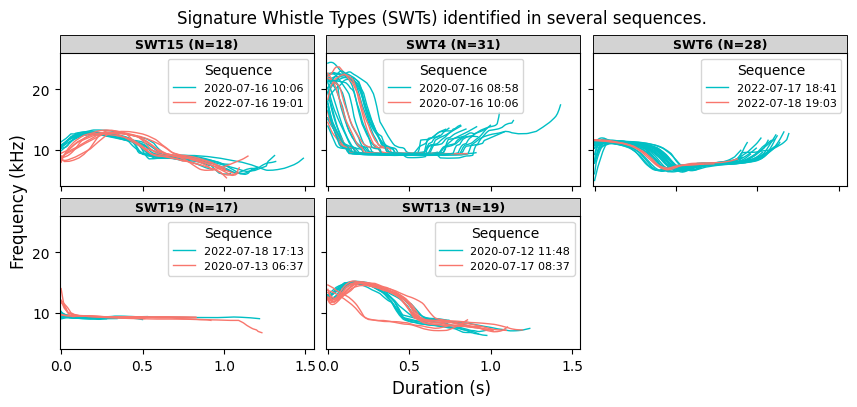

In [19]:
shared_sequence = categories_multi_dates(results_df[results_df[the_interval]], "sequence")

colors = ["#00BFC4","#F8766D"]

# plot them per sequence
side_length = [2, 3]
fig, axs = plt.subplots(side_length[0], side_length[1], sharex=True, sharey=True, figsize=(9,4))

# fill in the contours
curr_grid = [0, 0]

for cat_id, cat_name in enumerate(shared_sequence.category.unique()):
    axs[curr_grid[0],curr_grid[1]].set_title(
        f"SWT{cat_name} (N={len(shared_sequence[shared_sequence.category == cat_name])})",
        pad=3.5, 
        fontsize=9,
        fontweight='bold')  
    
    hue_values = {
        value: colors[i%len(colors)] 
        for i, value in 
        enumerate(shared_sequence[shared_sequence.category == cat_name]["sequence"].unique())
    }

    for id_contour, contour in shared_sequence[shared_sequence.category == cat_name].iterrows():
        with open(os.path.join("./resources/DF-whistles/smooth/all", id_contour), "r") as f:
            json_contour = json.load(f)

        axs[curr_grid[0],curr_grid[1]].plot(
            np.array(json_contour["time"])-min(json_contour["time"]),
            np.array(json_contour["frequency"])/1000,
            lw=1, alpha=1,
            color=hue_values[shared_sequence.loc[id_contour, "sequence"]], 
            label=shared_sequence.loc[id_contour, "sequence"]
        )
    
    axs[curr_grid[0],curr_grid[1]].add_patch(
            plt.Rectangle(
                xy=(-0.01, 26), 
                width=1.56, 
                height=3,
                facecolor='lightgray',
                clip_on=False,
                edgecolor="black",
                linewidth = .66))
    
    # make each label unique
    handles, labels = axs[curr_grid[0],curr_grid[1]].get_legend_handles_labels()
    labels = [label.replace("_", " ") for label in labels]
    unique_labels = dict(zip(labels, handles))
    axs[curr_grid[0],curr_grid[1]].legend(
        unique_labels.values(), unique_labels.keys(),
        title="Sequence", prop={"size":8}, fontsize=6)

    if curr_grid[1] >= side_length[1]-1:
        curr_grid[0] += 1
        curr_grid[1] = 0
    else:
        curr_grid[1] += 1


axs[0,0].set_xlim(-0.01,1.55)
axs[0,0].set_ylim(4,26)
fig.supylabel("Frequency (kHz)")
fig.supxlabel("Duration (s)")
fig.delaxes(axs[-1, -1])
fig.suptitle("Signature Whistle Types (SWTs) identified in several sequences.")

fig.subplots_adjust(
    left=0.075, right=0.95,
    bottom=0.13, top=0.87,
    wspace=0.05, hspace=0.225)
fig.savefig("/home/loic/Pictures/CDD/SWTs_shared_sequences.pdf")
plt.show()

These SWTs shared between sequences could have multiple explanations:
- Different groups contained the same 2 individuals, that were not noticed by the observers onboard.
- Contours with very similar shapes, but with fine variations, associated to different but closely related individuals.
- misclassification errors of the ARTwarp algorithm (fine variations are visible, but would need a stricter vigilance value to be differentiated).

Both these hypotheses are plausible. In practice, shared SWTs are very rare in our dataset.

In [20]:
print(
    categories_multi_dates(results_df[results_df[the_interval]], "year").category.nunique(),
    f"SWTs are shared between years.")
print(
    categories_multi_dates(results_df[results_df[the_interval]], "date").category.nunique(),
    f"SWTs are shared between days.")
print(
    categories_multi_dates(results_df[results_df[the_interval]], "sequence").category.nunique(),
    f"SWTs are shared between sequences.")

2 SWTs are shared between years.
4 SWTs are shared between days.
5 SWTs are shared between sequences.


When considering all WCTs, more types are shared between sequences/days. But by definition, these WCTs are not specific to individuals as they are not SWs, so they could be shared by several dolphins and/or groups of dolphins, with various applications that are unknown to this day.

### Average frequency

In [21]:
wct_average_freq = []
swt_average_freq = []

for id_row, row in tqdm(results_df.iterrows(), total=len(results_df)):
    with open(os.path.join("./resources/DF-whistles/smooth/all", id_row)) as f:
        coords = json.load(f)

    x = np.array(coords["time"])
    y = np.array(coords["frequency"])
    y = y[np.argsort(x)]

    # Mean Frequency 
    if row["is_SW"] == 1:
        swt_average_freq += [np.mean(y)/1000]
    else:
        wct_average_freq += [np.mean(y)/1000]

100%|██████████| 11575/11575 [00:04<00:00, 2534.04it/s]


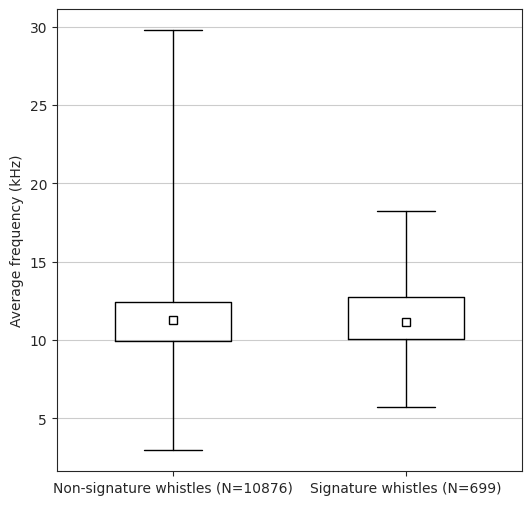

In [22]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(6,6))
box = ax.boxplot(
    x=[wct_average_freq, swt_average_freq],
    widths=0.5,
    showfliers=False,
    medianprops=dict(linestyle='none'),
    whis=(0, 100)
    )

for i, line in enumerate(box['medians']):
    median_x = (line.get_xdata()[0] + line.get_xdata()[1]) / 2  # Center of the box
    median_y = line.get_ydata()[0]  # Median value
    plt.plot(
        median_x, median_y, 
        marker='s', markersize=6, markeredgewidth=1,
        markerfacecolor='none', markeredgecolor='black') 


ax.set_xticks(
    [1, 2],
    [
        f"Non-signature whistles (N={len(wct_average_freq)})", 
        f"Signature whistles (N={len(swt_average_freq)})"
    ])
ax.set_ylabel("Average frequency (kHz)")
ax.yaxis.grid(True)
fig.savefig("/home/loic/Pictures/CDD/boxplot_freq.pdf")
plt.show()
sns.reset_orig()

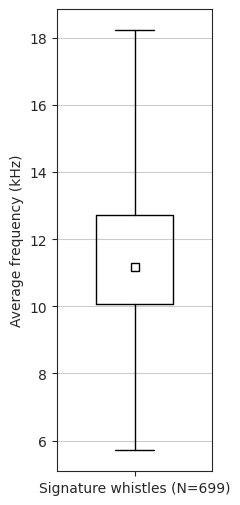

In [23]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(2,6))
box = ax.boxplot(
    x=[swt_average_freq],
    widths=0.5,
    showfliers=False,
    medianprops=dict(linestyle='none'),
    whis=(0, 100)
    )

for i, line in enumerate(box['medians']):
    median_x = (line.get_xdata()[0] + line.get_xdata()[1]) / 2  # Center of the box
    median_y = line.get_ydata()[0]  # Median value
    plt.plot(
        median_x, median_y, 
        marker='s', markersize=6, markeredgewidth=1,
        markerfacecolor='none', markeredgecolor='black') 


ax.set_xticks(
    [1],
    [f"Signature whistles (N={len(swt_average_freq)})"]
    )
ax.set_ylabel("Average frequency (kHz)")
ax.yaxis.grid(True)
fig.savefig("/home/loic/Pictures/CDD/SWT_boxplot_freq.pdf")
plt.show()
sns.reset_orig()

In [24]:
# SWT average frequency, confidence interval
print("Average frequency (kHz) of SWs:")
print(f"Max: {np.max(swt_average_freq):.2f}")
print(f"75%: {np.quantile(swt_average_freq, 0.75):.2f}")
# print(f"Mean: {np.mean(swt_average_freq):.2f}")
print(f"Median: {np.median(swt_average_freq):.2f}")
print(f"25%: {np.quantile(swt_average_freq, 0.25):.2f}")
print(f"Min: {np.min(swt_average_freq):.2f}")

Average frequency (kHz) of SWs:
Max: 18.23
75%: 12.72
Median: 11.17
25%: 10.08
Min: 5.71


### SWTs proportion

Let's investigate if the proportion SWs/whistles varies depeding on our recorded variables.

Why? Because I've seen it here [Janik et al. 1994](http://link.springer.com/10.1007/BF00170704)

#### Behavioural state

In [25]:
# test data
print("Fisher's exact tests:")
test_behaviours = pairwise_tests(results_df, "behaviour", "is_SW")
for test_behaviour in test_behaviours:
    if type(test_behaviour[0])==str and type(test_behaviour[1])==str:
        print("\t", test_behaviour[0], "VS", test_behaviour[1], f": (odds ratio={test_behaviour[3]:.2f})", f"{test_behaviour[2]:.2e}", get_stars(test_behaviour[2]))

Fisher's exact tests:
	 Socialising VS Foraging : (odds ratio=0.47) 2.39e-03 **
	 Socialising VS Travelling : (odds ratio=0.46) 1.98e-03 **
	 Socialising VS Attraction : (odds ratio=0.54) 1.52e-02 *
	 Socialising VS Milling : (odds ratio=0.34) 1.45e-04 ***
	 Foraging VS Travelling : (odds ratio=0.98) 8.41e-01 ns
	 Foraging VS Attraction : (odds ratio=1.14) 1.96e-01 ns
	 Foraging VS Milling : (odds ratio=0.72) 5.35e-02 ns
	 Travelling VS Attraction : (odds ratio=1.17) 1.20e-01 ns
	 Travelling VS Milling : (odds ratio=0.74) 6.93e-02 ns
	 Attraction VS Milling : (odds ratio=0.63) 7.18e-03 **


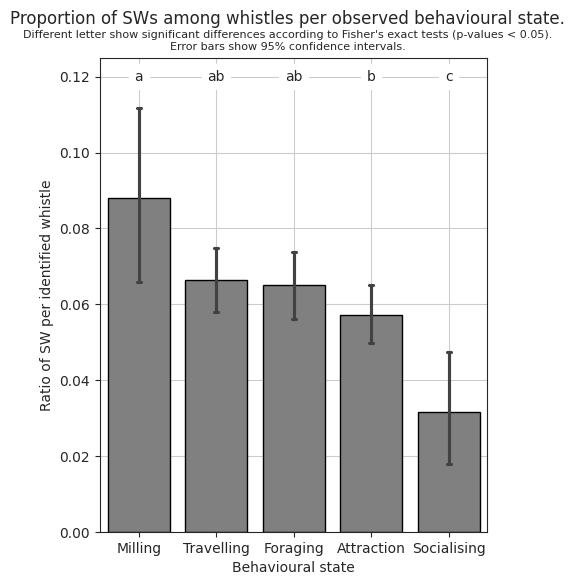

In [26]:
# Make plot
letters = ["a", "ab", "ab", "b", "c"] # manually from previous cell
behavioural_states = ["Milling", "Travelling", "Foraging", "Attraction", "Socialising"]

sns.set_style("ticks")
fig_behaviour, axs_behaviour = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="behaviour", y="is_SW",
    capsize=0.05, width=0.8, order=behavioural_states,
    n_boot=10000, seed=42, ax=axs_behaviour, 
    color="gray", edgecolor="black"
)
axs_behaviour.set_ylim(0,0.125)
for i, x in enumerate(behavioural_states):
    axs_behaviour.text(
        str(x), 0.12, letters[i], ha="center", va="center", fontsize=10,
        backgroundcolor="white"
    )
axs_behaviour.set_xlabel("Behavioural state")
axs_behaviour.set_ylabel("Ratio of SW per identified whistle")
fig_behaviour.suptitle("Proportion of SWs among whistles per observed behavioural state.")
fig_behaviour.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_behaviour.set_size_inches(5, 6)
fig_behaviour.subplots_adjust(
    top=0.9
)
axs_behaviour.xaxis.grid(True)
axs_behaviour.yaxis.grid(True)
fig_behaviour.savefig("/home/loic/Pictures/CDD/barplot_behaviours.pdf")
plt.show()
sns.reset_orig()

In [27]:
results_df.groupby("behaviour")["is_SW"].mean()*100

behaviour
Attraction     5.720890
Foraging       6.494346
Milling        8.791209
Socialising    3.168317
Travelling     6.629180
Name: is_SW, dtype: float64

Kind of the opposite of what we were expecting : socialising dolphins interact with each others, so we could have supposed that they were adressing each other (using each other's names) more often. But it is quite the opposite.

#### Beacon activation state

Does the DOLPHINFREE device has an influence on the emission of SWs?

In [28]:
# test data
print("Fisher's exact tests:")
test_beacons = pairwise_tests(results_df, "clean_activation_state", "is_SW")
for test_beacon in test_beacons:
    print("\t", test_beacon[0], "VS", test_beacon[1], f": (odds ratio={test_beacon[3]:.2f})", f"{test_beacon[2]:.2e}", get_stars(test_beacon[2]))

Fisher's exact tests:
	 DUR VS BEF : (odds ratio=1.70) 8.15e-08 ***
	 DUR VS DUR+AFT : (odds ratio=1.08) 7.04e-01 ns
	 DUR VS AFT : (odds ratio=0.85) 2.82e-01 ns
	 DUR VS BEF+DUR : (odds ratio=0.58) 5.80e-05 ***
	 BEF VS DUR+AFT : (odds ratio=0.63) 9.98e-03 **
	 BEF VS AFT : (odds ratio=0.50) 3.96e-05 ***
	 BEF VS BEF+DUR : (odds ratio=0.34) 3.02e-12 ***
	 DUR+AFT VS AFT : (odds ratio=0.79) 2.75e-01 ns
	 DUR+AFT VS BEF+DUR : (odds ratio=0.54) 1.00e-03 **
	 AFT VS BEF+DUR : (odds ratio=0.68) 3.41e-02 *


/tmp/ipykernel_2272100/1120395603.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_beacon.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])


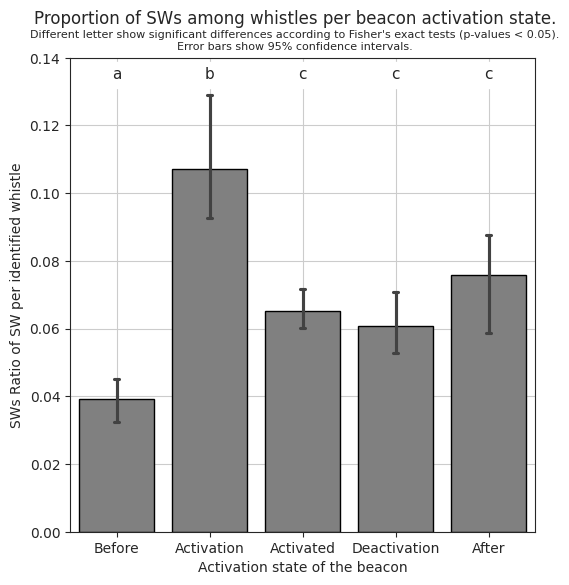

In [29]:
# Make plot
letters = ["a", "b", "c", "c", "c"] # manually from previous cell
activation_order = ["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"]

sns.set_style("ticks")
fig_beacon, axs_beacon = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="clean_activation_state", y="is_SW",
    capsize=0.05, width=0.8, order=activation_order,
    n_boot=30, seed=1, ax=axs_beacon,
    color="gray", edgecolor="black"
)
# since seaborn uses bootstrap, results are kinda different unfortunately.

axs_beacon.set_ylim(0,0.14)
for i, x in enumerate(activation_order):
    axs_beacon.text(
        str(x), 0.135, letters[i], ha="center", va="center", fontsize=11,
        backgroundcolor="white"
    )
axs_beacon.set_xlabel("Activation state of the beacon")
axs_beacon.set_ylabel("SWs Ratio of SW per identified whistle")
axs_beacon.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
fig_beacon.suptitle("Proportion of SWs among whistles per beacon activation state.")
fig_beacon.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_beacon.set_size_inches(6, 6)
fig_beacon.subplots_adjust(
    top=0.9
)
axs_beacon.xaxis.grid(True)
axs_beacon.yaxis.grid(True)
fig_beacon.savefig("/home/loic/Pictures/CDD/barplot_beacons.pdf")
plt.show()
sns.reset_orig()

In [30]:
results_df.groupby("clean_activation_state")["is_SW"].mean()*100
# results_df[(
#     (results_df.clean_activation_state == "DUR") |
#     (results_df.clean_activation_state == "DUR+AFT") |
#     (results_df.clean_activation_state == "AFT") 
# )]["is_SW"].mean()*100

clean_activation_state
AFT         7.573813
BEF         3.934795
BEF+DUR    10.704961
DUR         6.513274
DUR+AFT     6.082725
Name: is_SW, dtype: float64

It looks like, at the activation of the beacon, the ratio of SWs increases.

#### Fishing net

An influence of the presence/absence of a fishing net?

In [31]:
# test data
print("Fisher's exact tests:")
test_nets = pairwise_tests(results_df, "fishing_net", "is_SW")
for test_net in test_nets:
    print("\t", test_net[0], "VS", test_net[1], f": (odds ratio={test_net[3]:.2f})", f"{test_net[2]:.2e}", get_stars(test_net[2]))

Fisher's exact tests:
	 Absent VS Present : (odds ratio=1.33) 3.40e-04 ***


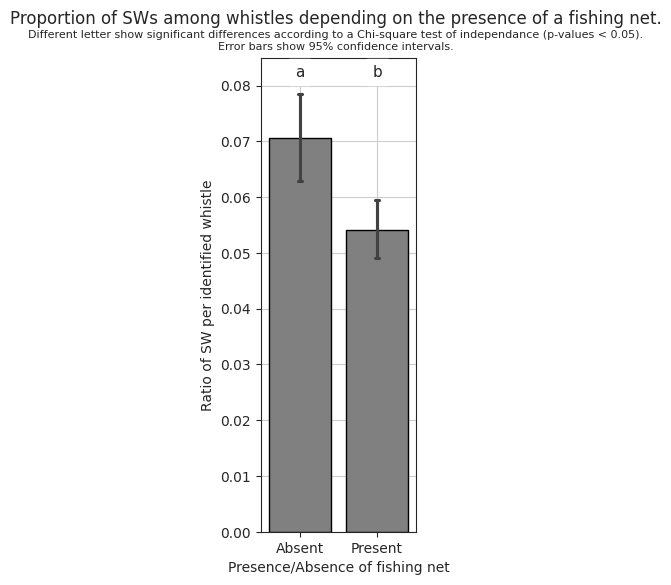

In [32]:
# Make plot
letters = ["a", "b"]

sns.set_style("ticks")
fig_net, axs_net = plt.subplots(1,1)
sns.barplot(
    data=results_df, x="fishing_net", y="is_SW",
    capsize=0.05, width=0.8,
    n_boot=10000, seed=10, ax=axs_net,
    color="gray", edgecolor="black"
)
axs_net.set_ylim(0,0.085)
for i, x in enumerate(["Absent", "Present"]):
    axs_net.text(
        str(x), 0.08105, letters[i], ha="center", va="bottom", fontsize=11,
        backgroundcolor="white"
    )

fig_net.suptitle("Proportion of SWs among whistles depending on the presence of a fishing net.")
fig_net.text(
    0.5, 0.91,
    "Different letter show significant differences according to a Chi-square test of independance (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_net.set_size_inches(2, 6)
fig_net.subplots_adjust(
    top=0.9
)
axs_net.set_xlabel("Presence/Absence of fishing net")
axs_net.set_ylabel("Ratio of SW per identified whistle")
axs_net.xaxis.grid(True)
axs_net.yaxis.grid(True)
fig_net.savefig("/home/loic/Pictures/CDD/barplot_net.pdf")
plt.show()
sns.reset_orig()

In [33]:
results_df.groupby("fishing_net")["is_SW"].mean()*100

fishing_net
Absent     7.066332
Present    5.411797
Name: is_SW, dtype: float64

Well, that one is easy to interpret at least. More SWs when no fishing net, less when the fishing net is absent. Dolphin might be using signals other than SWs to communicate about a danger in their environment.

#### Group size

The more dolphins, the more whistles (with a log increase). But are there also more SWs in proportion ?

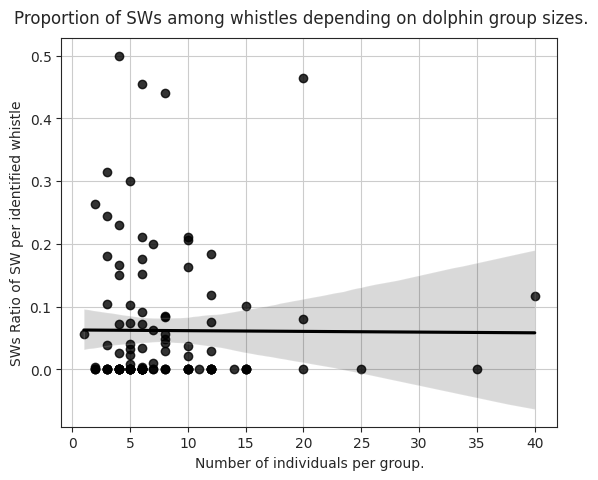

Spearman correlation: -0.04 (p-value 0.70)


In [34]:
ratio_df = results_df.groupby(['sequence', 'group_size'])['is_SW'].mean().reset_index()

sns.set_style("ticks")
fig_size, axs_size = plt.subplots(1,1)
sns.regplot(
    data=ratio_df, x='group_size', y='is_SW',
    scatter=True, ax=axs_size,
    color="black"
)
fig_size.suptitle("Proportion of SWs among whistles depending on dolphin group sizes.")
# fig_size.set_size_inches(2, 6)
fig_size.subplots_adjust(
    top=0.92
)
axs_size.set_xlabel("Number of individuals per group.")
axs_size.set_ylabel("SWs Ratio of SW per identified whistle")
axs_size.xaxis.grid(True)
axs_size.yaxis.grid(True)
fig_size.savefig("/home/loic/Pictures/CDD/regplot_group_size.pdf")
plt.show()
sns.reset_orig()

r = stats.spearmanr(
    ratio_df["group_size"], 
    ratio_df["is_SW"])

print(f"Spearman correlation: {r[0]:.2f} (p-value {r[1]:.2f})")

No relation between SW proportion and group size. It was expected, but its still better to prove it.

#### Activation sequence VS behaviour

Let's try some chosen interactions, to investigate further.

/tmp/ipykernel_2272100/3172432998.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  interaction_axs.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])


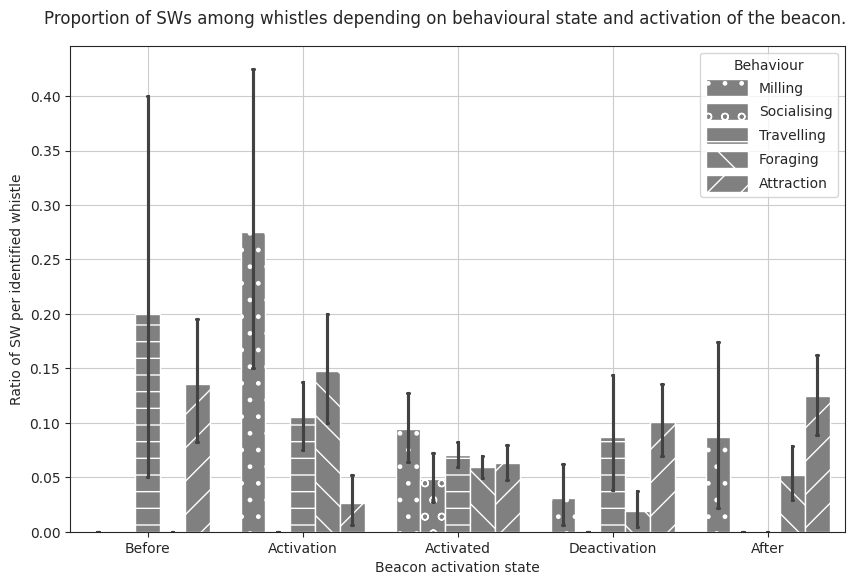

In [35]:
sns.set_style("ticks")
interaction_fig, interaction_axs = plt.subplots(1,1)
hue_order=["Milling", "Socialising", "Travelling", "Foraging", "Attraction"]
bars = sns.barplot(
    data=results_df, x="activation_state", y="is_SW", hue="behaviour",
    capsize=0.05, width=0.8, 
    order=["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"], 
    hue_order=hue_order,
    n_boot=10000, seed=42, ax=interaction_axs,
)

# Apply hatch patterns : ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
unique_colors = np.unique(np.array([bar.get_facecolor() for bar in bars.patches]), axis=0)
hatch_patterns = ['.', '-', '/', '\\', 'o']
for bar in bars.patches:
    color = bar.get_facecolor()
    index = [i for i, unique_color in enumerate(unique_colors) if np.all(unique_color == color)]
    bar.set_hatch(hatch_patterns[index[0]])
    bar.set_facecolor('gray')
interaction_axs.legend(title="Behaviour", handlelength=3, handleheight=1.5)

interaction_fig.set_size_inches(10, 6)
interaction_fig.suptitle("Proportion of SWs among whistles depending on behavioural state and activation of the beacon.")
interaction_fig.subplots_adjust(
    top=0.92
)
interaction_axs.set_xlabel("Beacon activation state")
interaction_axs.set_ylabel("Ratio of SW per identified whistle")
interaction_axs.xaxis.grid(True)
interaction_axs.yaxis.grid(True)
interaction_axs.set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
interaction_fig.savefig("/home/loic/Pictures/CDD/regplot_interaction_beahviour_beacon.pdf")
plt.show()
sns.reset_orig()

Too many variations and missing modalities, cannot easily determine true variations

#### Fishing net interactions

The presence of a fishing has no effect alone. But maybe when considering interactions it reveals an effect?

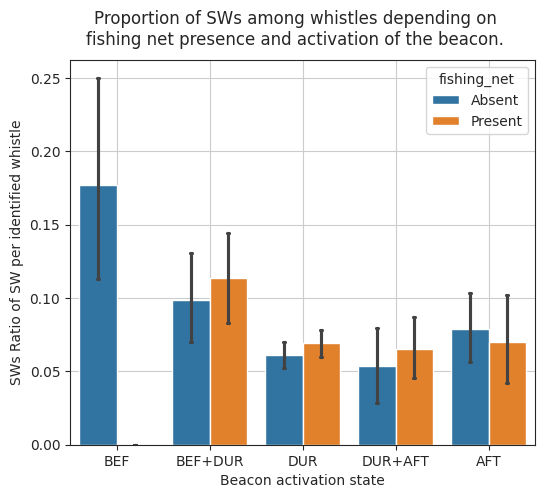

In [36]:
sns.set_style("ticks")
net_interaction_fig, net_interaction_axs = plt.subplots(1,1)
bars = sns.barplot(
    data=results_df, x="activation_state", y="is_SW", hue="fishing_net",
    capsize=0.05, width=0.8, 
    order=["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"], 
    hue_order=["Absent", "Present"],
    n_boot=10000, seed=42, ax=net_interaction_axs,
)

net_interaction_fig.set_size_inches(6, 5)
net_interaction_fig.suptitle("Proportion of SWs among whistles depending on\nfishing net presence and activation of the beacon.")
net_interaction_fig.subplots_adjust(top=0.88)
net_interaction_axs.set_xlabel("Beacon activation state")
net_interaction_axs.set_ylabel("SWs Ratio of SW per identified whistle")
net_interaction_axs.xaxis.grid(True)
net_interaction_axs.yaxis.grid(True)
plt.show()
sns.reset_orig()

Interesting to see that for "BEF" category, no SW was identified when a fishing net was present. Could be a sampling issue though.

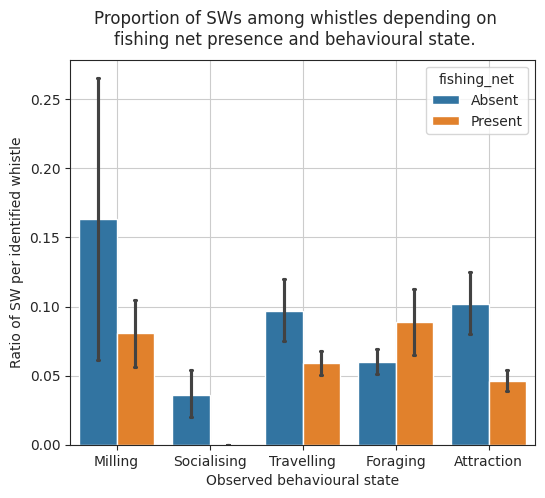

In [37]:
sns.set_style("ticks")
net_interaction_fig, net_interaction_axs = plt.subplots(1,1)
bars = sns.barplot(
    data=results_df, x="behaviour", y="is_SW", hue="fishing_net",
    capsize=0.05, width=0.8, 
    order=["Milling", "Socialising", "Travelling", "Foraging", "Attraction"], 
    hue_order=["Absent", "Present"],
    n_boot=10000, seed=42, ax=net_interaction_axs,
)

net_interaction_fig.set_size_inches(6, 5)
net_interaction_fig.suptitle("Proportion of SWs among whistles depending on\nfishing net presence and behavioural state.")
net_interaction_fig.subplots_adjust(top=0.88)
net_interaction_axs.set_xlabel("Observed behavioural state")
net_interaction_axs.set_ylabel("Ratio of SW per identified whistle")
net_interaction_axs.xaxis.grid(True)
net_interaction_axs.yaxis.grid(True)
plt.show()
sns.reset_orig()

Some interaction is visible for attraction and travelling. But nothing really surprising compared to fishing net effects alone.